# Flex Net: A Configurable Neural Network for Sound Parsing

### Avant Garde Composer

Code to generate batches of random marimba compositions (with piano roll and corresponding audio)

In [1]:
import tensorflow as tf
from sonic2 import *

class Generate_Batch():
    def __init__(self, batch_size, length_in_beats, sample_rate, bpm):
        self.song = Song(SampleBank(restricted_instruments=['Marimba_cord_ff']),
                         length_in_beats, bpm, sample_rate)
        self.batch_size = batch_size
        self.num_inst_samples = self.song.num_inst_samples
        self.length_in_beats = length_in_beats
        self.bpm = bpm
        self.sr = sample_rate
        self.N = self.sr * self.length_in_beats * 60 // self.bpm
        self.samples_per_beat = (self.sr * 60) // self.bpm
        self.batch_audio = tf.Variable(tf.zeros([self.batch_size, self.length_in_beats-4, self.samples_per_beat*5], dtype=tf.float32))
        self.batch_piano_roll = tf.Variable(tf.zeros([self.batch_size, self.length_in_beats-4, self.num_inst_samples], dtype=tf.float32))
    
    #@tf.function
    def __chop__(self, song_output, song_notes_float):
        audio = tf.TensorArray(tf.float32, size=(self.length_in_beats-4), element_shape=(self.samples_per_beat*5,))
        piano_roll = tf.TensorArray(tf.float32, size=(self.length_in_beats-4), element_shape=(self.num_inst_samples,))
        for j in tf.range(2, self.song.length_in_beats - 2):
            audio = audio.write(j-2, song_output[(j-2)*self.samples_per_beat:(j+3)*self.samples_per_beat])
            piano_roll = piano_roll.write(j-2, tf.reshape(song_notes_float, [self.song.length_in_beats, self.song.num_inst_samples])[j])
        return audio.stack(), piano_roll.stack()
    
    @tf.function
    def __call2__(self):
        for i in range(self.batch_size):
            output, notes_float = self.song.create()
            audio, piano_roll = self.__chop__(output, notes_float)
            self.batch_audio[i].assign(audio)
            self.batch_piano_roll[i].assign(piano_roll)
        return self.batch_audio, self.batch_piano_roll

    #@tf.function
    def __call__(self):
        for i in range(self.batch_size):
            self.song.zero()
            for j in range(np.random.choice([3,4,5,6,7,8,9,10,11,12])):
                self.song.generate()
            audio, piano_roll = self.__chop__(self.song.output, self.song.notes_float)
            self.batch_audio[i].assign(audio)
            self.batch_piano_roll[i].assign(piano_roll)
        return self.batch_audio, self.batch_piano_roll    

In [2]:
batch_size = 10
batches_per_epoch = 10

generate_batch = Generate_Batch(batch_size, 4*10, 44100, 60*10)

Marimba_cord_ff  --- notes  36  through  96


In [3]:
a, p = generate_batch()

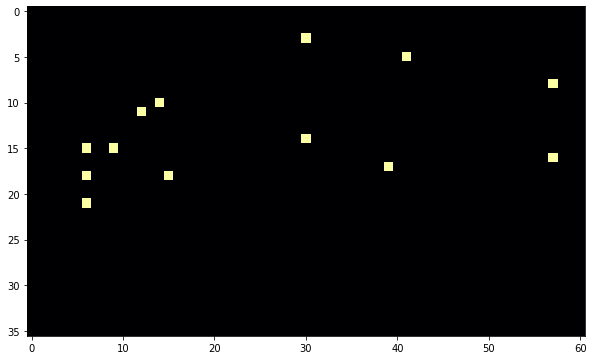

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,10))

ax.imshow(p[0].numpy(), aspect=(1), cmap='inferno')

In [6]:
# Example of a random composition

from IPython.display import Audio

generate_batch.song.generate()
example_composition = generate_batch.song.output.numpy()

Audio(example_composition, rate=44100, autoplay=True)

## Neural Network Classes

In [7]:
from neural2 import *

class Network(tf.Module):
    def __init__(self, name=None):
        super(Network, self).__init__(name=name)
        self.layers = []
        
                
        sample_rate = 44100                 # 44.1khz sample rate
        frame_length = sample_rate // 10    # frame size of 0.1 seconds
        num_frames = 5                      # five frames read at a time
        input_features = int(frame_length * num_frames)
    
        self.layers.append(DisperseLayer(input_features, frame_length, 1.0))
        num_chunks = num_frames
        
        self.layers.append(RFFTLayer(self.layers[-1].chunk_size))
        
        self.layers.append(ReluNormLayer(self.layers[-1].output_features, self.layers[-1].output_features // 16))
        self.layers.append(ReluNormLayer(self.layers[-1].output_features, self.layers[-1].output_features // 2))
        self.layers.append(ReluNormLayer(self.layers[-1].output_features, self.layers[-1].output_features // 2))
    
        
        self.layers.append(JoinLayer(self.layers[-1].output_features, num_chunks))
        
        self.layers.append(ReluNormLayer(self.layers[-1].output_features, self.layers[-1].output_features))
        self.layers.append(ReluNormLayer(self.layers[-1].output_features, self.layers[-1].output_features // 4))
        self.layers.append(SigmoidLayer(self.layers[-1].output_features, 61))
        

    def save(self, path):
        if not os.path.exists(path):
            os.makedirs(path)
        for i, layer in enumerate(self.layers):
            if not os.path.exists(os.path.join(path, f'layer_{i}')):
                os.makedirs(os.path.join(path, f'layer_{i}'))
            layer.save(os.path.join(path, f'layer_{i}'))
            
    def load(self, path):
        for i, layer in enumerate(self.layers):
            layer.load(os.path.join(path, f'layer_{i}'))
        
    def apply(self, data, layers):
        if len(layers) == 1:
            return layers[0](data)
        else:
            return self.apply(layers[0](data), layers[1:])

    #@tf.function
    def __call__(self, data):
        x = data
        for i, layer in enumerate(self.layers):
            x = layer(x)
        return x
        #return self.apply(data, self.layers)
        
    def reset(self):
        for layer in self.layers:
            layer.reset()

network = Network()

Disperse Layer. Input Features: 22050 Chunk Size: 4410 Num Chunks: 5
RFFT Layer. Input Features: 4410 Output Features: 8194
RELU Layer. Input Features: 8194 Output Features: 512
RELU Layer. Input Features: 512 Output Features: 256
RELU Layer. Input Features: 256 Output Features: 128
Join Layer. Input Chunk Size: 128 Num Input Chunks: 5 Output Features: 640
RELU Layer. Input Features: 640 Output Features: 640
RELU Layer. Input Features: 640 Output Features: 160
Sigmoid Layer. Input Features: 160 Output Features: 61


In [8]:
def clean_output(arr):
    N = arr.shape[0]
    M = arr.shape[1]
    output = np.zeros([N, M])
    for i in range(N):
        for j in range(M):
            output[i][j] = int(max(0, min(127, round(128 * arr[i][j]))))
    return output

In [9]:
network.reset()

Epoch 79 completed!
Step 799 complete.
Cost: 0.178816348 Note Cost: 0.178816348 Regularization Cost: 5148.69238
Global Norm: 2.238161


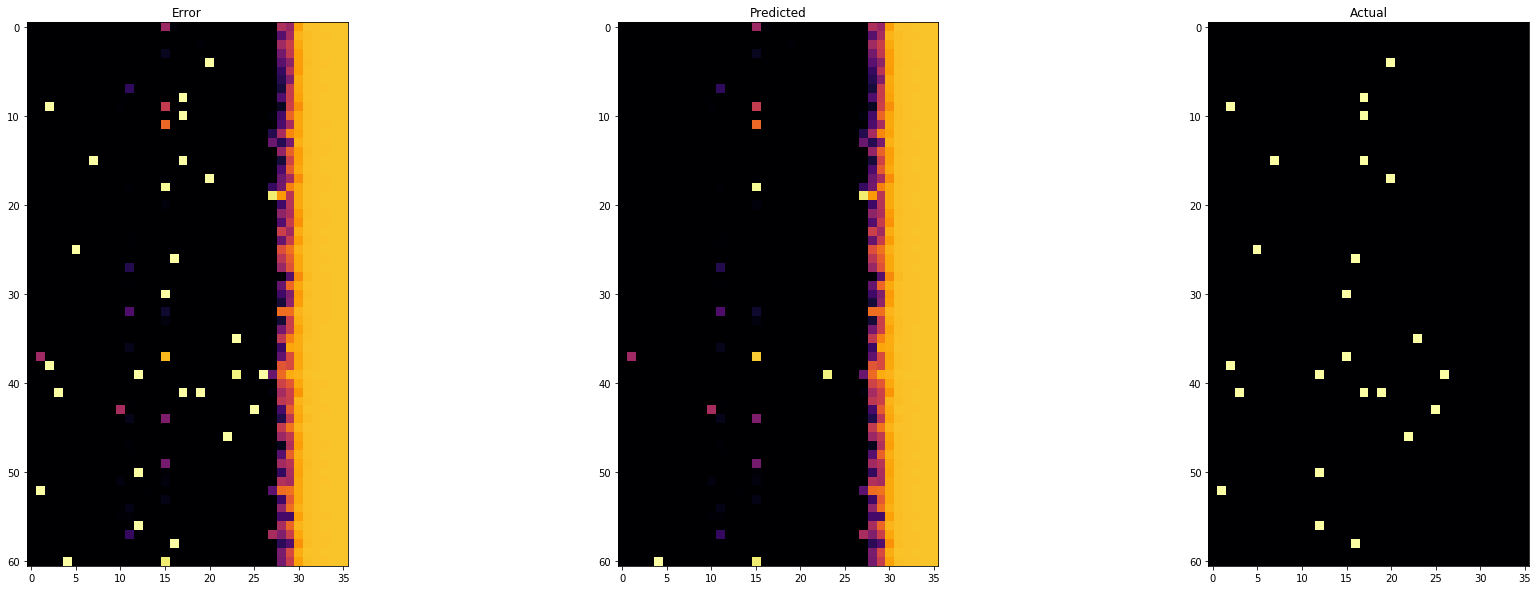

Step 800 complete.
Cost: 0.165003374 Note Cost: 0.165003374 Regularization Cost: 5148.69238
Global Norm: 5.434545
Step 801 complete.
Cost: 0.211722746 Note Cost: 0.211722746 Regularization Cost: 5148.69238
Global Norm: 2.2743354
Step 802 complete.
Cost: 0.184217125 Note Cost: 0.184217125 Regularization Cost: 5148.69238
Global Norm: 1.2782308
Step 803 complete.
Cost: 0.220383078 Note Cost: 0.220383078 Regularization Cost: 5148.69238
Global Norm: 2.45438
Step 804 complete.
Cost: 0.19146131 Note Cost: 0.19146131 Regularization Cost: 5148.69238
Global Norm: 1.3664783
Step 805 complete.
Cost: 0.170817509 Note Cost: 0.170817509 Regularization Cost: 5148.69238
Global Norm: 2.1537716
Step 806 complete.
Cost: 0.207577273 Note Cost: 0.207577273 Regularization Cost: 5148.69238
Global Norm: 18.205538
Step 807 complete.
Cost: 0.178319082 Note Cost: 0.178319082 Regularization Cost: 5148.69238
Global Norm: 6.1214814
Step 808 complete.
Cost: 0.177610099 Note Cost: 0.177610099 Regularization Cost: 5148

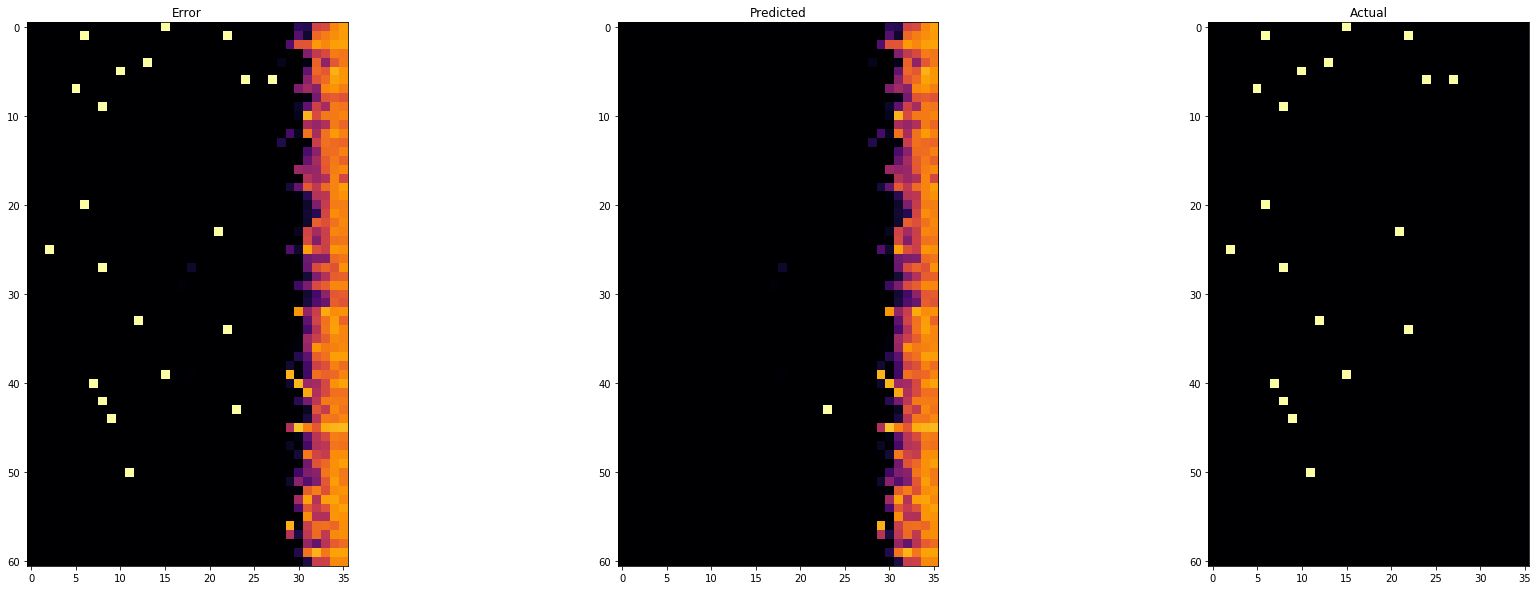

Step 810 complete.
Cost: 0.252539 Note Cost: 0.252539 Regularization Cost: 5148.69775
Global Norm: 2.0986845
Step 811 complete.
Cost: 0.227997512 Note Cost: 0.227997512 Regularization Cost: 5148.69775
Global Norm: 0.6532125
Step 812 complete.
Cost: 0.173829734 Note Cost: 0.173829734 Regularization Cost: 5148.69775
Global Norm: 0.8599106
Step 813 complete.
Cost: 0.168877676 Note Cost: 0.168877676 Regularization Cost: 5148.69775
Global Norm: 5.6072125
Step 814 complete.
Cost: 0.189553902 Note Cost: 0.189553902 Regularization Cost: 5148.69775
Global Norm: 2.1432834
Step 815 complete.
Cost: 0.198088169 Note Cost: 0.198088169 Regularization Cost: 5148.69775
Global Norm: 1.6871525
Step 816 complete.
Cost: 0.163417175 Note Cost: 0.163417175 Regularization Cost: 5148.69775
Global Norm: 2.6266847
Step 817 complete.
Cost: 0.174451292 Note Cost: 0.174451292 Regularization Cost: 5148.69775
Global Norm: 1.9603502
Step 818 complete.
Cost: 0.183716014 Note Cost: 0.183716014 Regularization Cost: 5148.

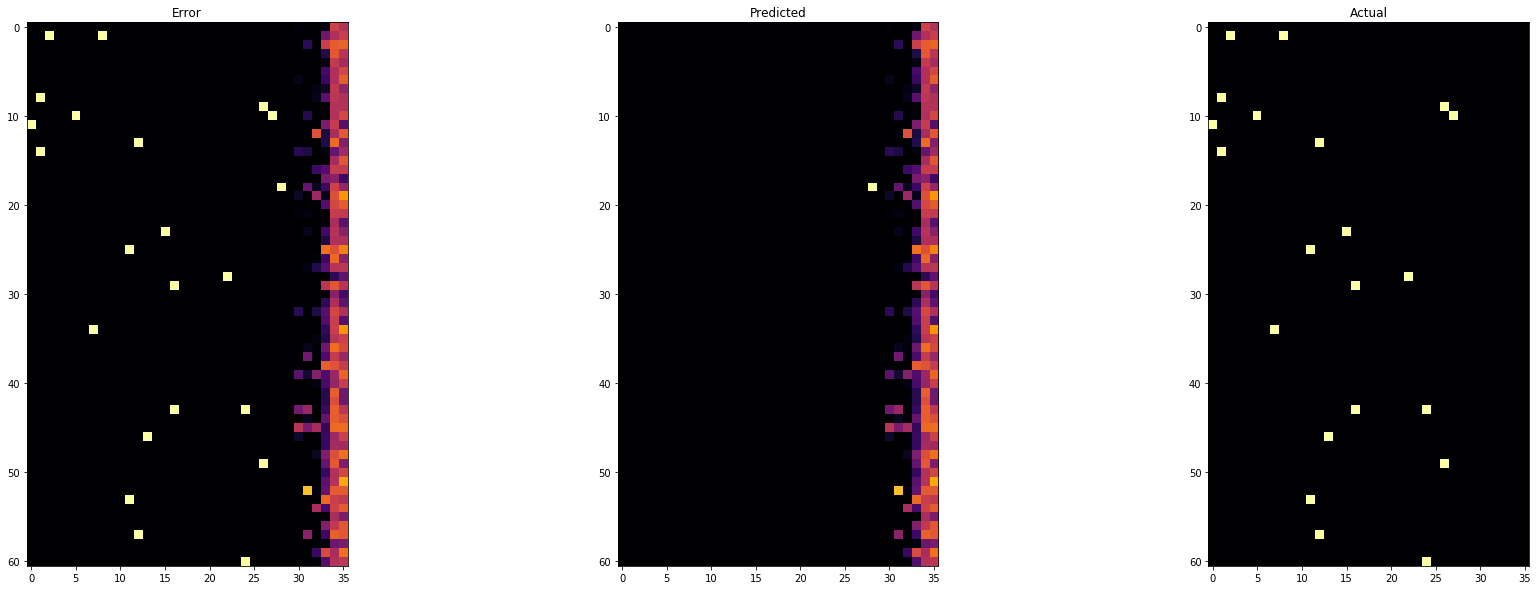

Step 820 complete.
Cost: 0.223478034 Note Cost: 0.223478034 Regularization Cost: 5148.70215
Global Norm: 3.2470295
Step 821 complete.
Cost: 0.185181215 Note Cost: 0.185181215 Regularization Cost: 5148.70215
Global Norm: 2.2616508
Step 822 complete.
Cost: 0.211522102 Note Cost: 0.211522102 Regularization Cost: 5148.70215
Global Norm: 2.010172
Step 823 complete.
Cost: 0.154855 Note Cost: 0.154855 Regularization Cost: 5148.70215
Global Norm: 1.8286355
Step 824 complete.
Cost: 0.211027846 Note Cost: 0.211027846 Regularization Cost: 5148.70215
Global Norm: 2.9287462
Step 825 complete.
Cost: 0.186098114 Note Cost: 0.186098114 Regularization Cost: 5148.70215
Global Norm: 2.4009507
Step 826 complete.
Cost: 0.206110835 Note Cost: 0.206110835 Regularization Cost: 5148.70215
Global Norm: 4.87325
Step 827 complete.
Cost: 0.214401424 Note Cost: 0.214401424 Regularization Cost: 5148.70215
Global Norm: 4.4506736
Step 828 complete.
Cost: 0.211960018 Note Cost: 0.211960018 Regularization Cost: 5148.702

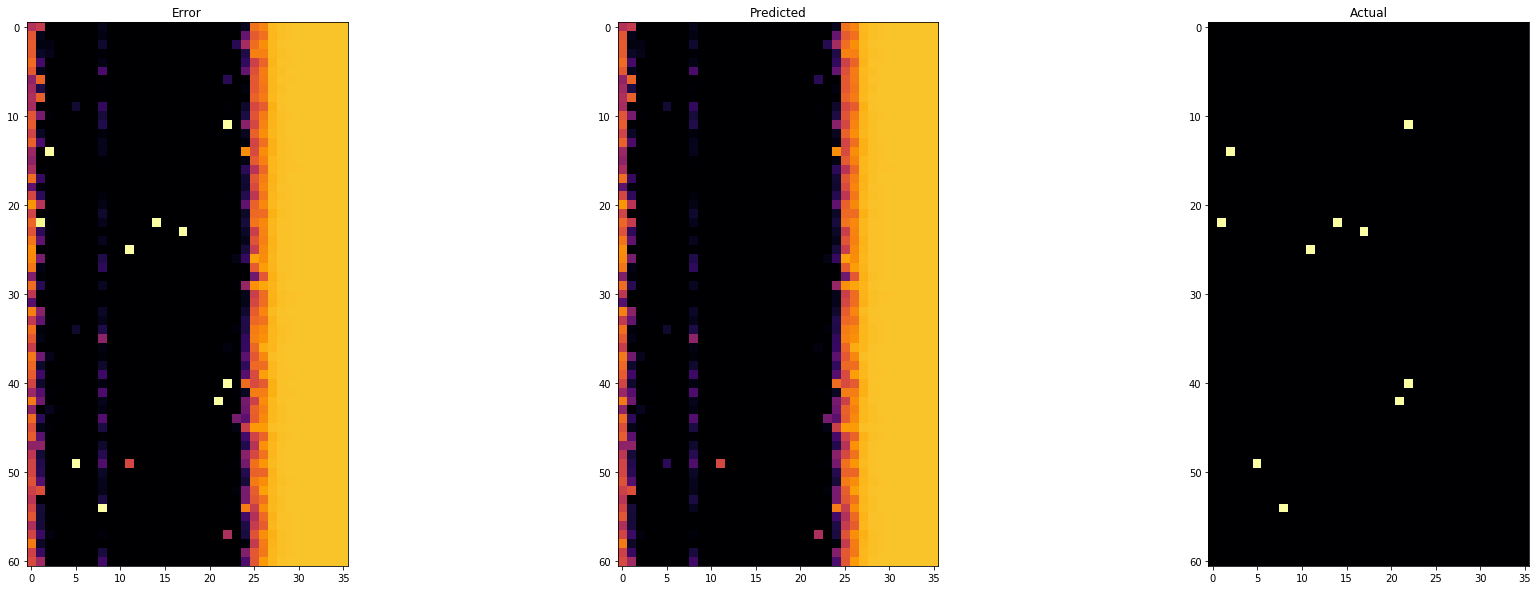

Step 830 complete.
Cost: 0.187774807 Note Cost: 0.187774807 Regularization Cost: 5148.70605
Global Norm: 1.4978653
Step 831 complete.
Cost: 0.172976121 Note Cost: 0.172976121 Regularization Cost: 5148.70605
Global Norm: 5.826251
Step 832 complete.
Cost: 0.181320548 Note Cost: 0.181320548 Regularization Cost: 5148.70605
Global Norm: 4.981767
Step 833 complete.
Cost: 0.166261792 Note Cost: 0.166261792 Regularization Cost: 5148.70605
Global Norm: 2.3190517
Step 834 complete.
Cost: 0.166351691 Note Cost: 0.166351691 Regularization Cost: 5148.70605
Global Norm: 5.430005
Step 835 complete.
Cost: 0.181213722 Note Cost: 0.181213722 Regularization Cost: 5148.70605
Global Norm: 2.7515867
Step 836 complete.
Cost: 0.188617572 Note Cost: 0.188617572 Regularization Cost: 5148.70605
Global Norm: 1.8171321
Step 837 complete.
Cost: 0.181240261 Note Cost: 0.181240261 Regularization Cost: 5148.70605
Global Norm: 4.702306
Step 838 complete.
Cost: 0.151206046 Note Cost: 0.151206046 Regularization Cost: 514

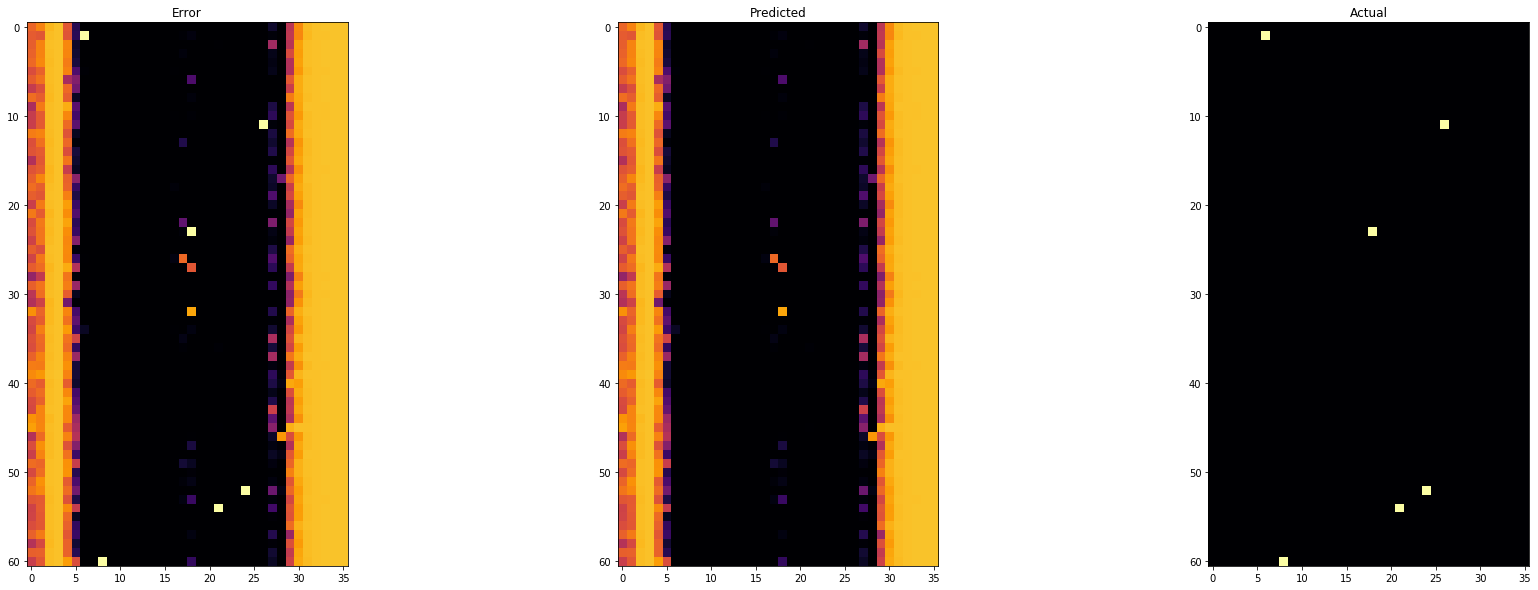

Step 840 complete.
Cost: 0.198531017 Note Cost: 0.198531017 Regularization Cost: 5148.71
Global Norm: 2.324234
Step 841 complete.
Cost: 0.190957278 Note Cost: 0.190957278 Regularization Cost: 5148.71
Global Norm: 3.94505
Step 842 complete.
Cost: 0.213920936 Note Cost: 0.213920936 Regularization Cost: 5148.71
Global Norm: 1.9389266
Step 843 complete.
Cost: 0.201936 Note Cost: 0.201936 Regularization Cost: 5148.71
Global Norm: 1.5305005
Step 844 complete.
Cost: 0.165741816 Note Cost: 0.165741816 Regularization Cost: 5148.71
Global Norm: 1.2795482
Step 845 complete.
Cost: 0.167510793 Note Cost: 0.167510793 Regularization Cost: 5148.71
Global Norm: 2.7290056
Step 846 complete.
Cost: 0.167863742 Note Cost: 0.167863742 Regularization Cost: 5148.71
Global Norm: 1.1405802
Step 847 complete.
Cost: 0.207251593 Note Cost: 0.207251593 Regularization Cost: 5148.71
Global Norm: 3.9140384
Step 848 complete.
Cost: 0.17361851 Note Cost: 0.17361851 Regularization Cost: 5148.71
Global Norm: 1.6051251
Epo

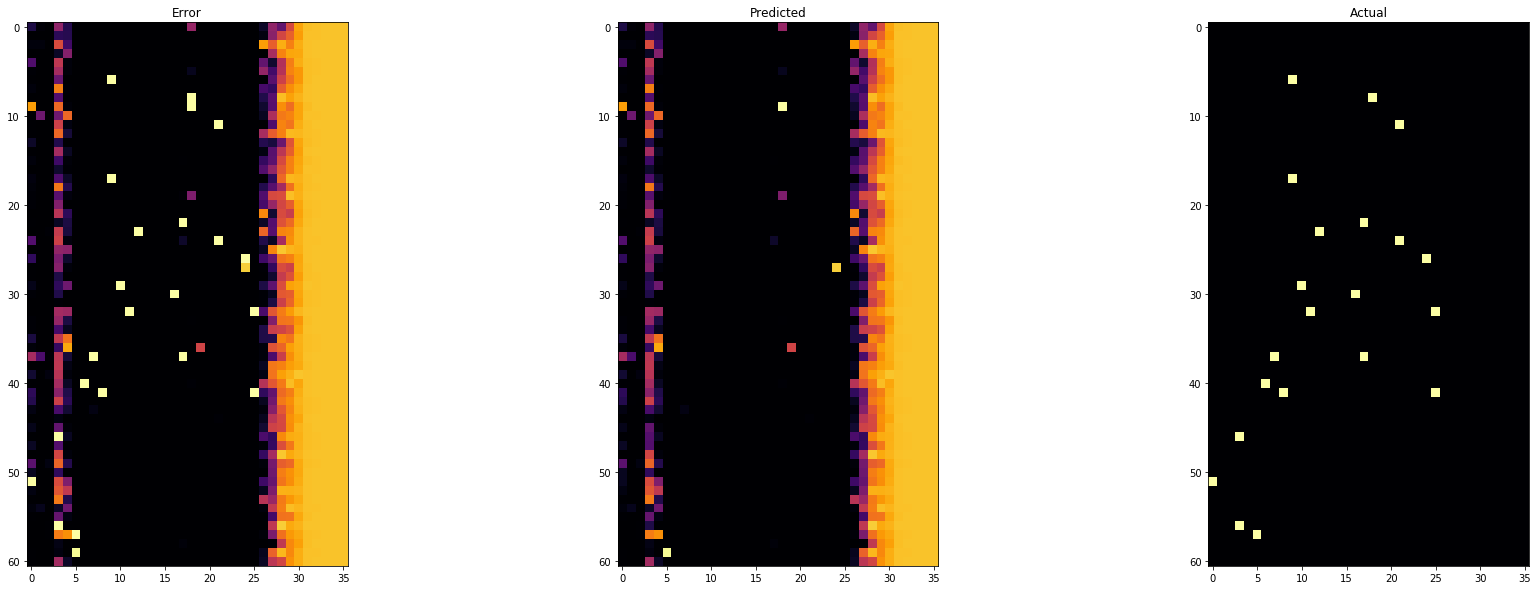

Step 850 complete.


In [ ]:
from IPython.display import display, clear_output, Audio
import seaborn as sns
import sys, signal
import matplotlib.pyplot as plt
import plotting

keep_going = True
def signal_handler(signal, frame):
    global keep_going
    keep_going = False
signal.signal(signal.SIGINT, signal_handler)

#@tf.function
def loss(trainable_variables, notes_actual, notes_predicted):
    note_cost = tf.reduce_mean(-notes_actual * tf.math.log(0.0001 + notes_predicted) - (1 - notes_actual) * tf.math.log(1.0001 - notes_predicted))
    regularization_cost = 0.0
    for i in range(len(trainable_variables)):
        regularization_cost +=  tf.reduce_sum(trainable_variables[i] ** 2)
    cost = note_cost #+ (1/100000) * regularization_cost
    tf.print('Cost:', cost, 'Note Cost:', note_cost, 'Regularization Cost:', regularization_cost)
    return cost
    

@tf.function
def grad(network, input_pcms, notes_actual):
    with tf.GradientTape() as tape:
        tape.watch(network.trainable_variables)
        notes_predicted = network(input_pcms)
        loss_value = loss(network.trainable_variables, notes_actual, notes_predicted)
    return loss_value, notes_predicted, tf.clip_by_global_norm(tape.gradient(loss_value, network.trainable_variables), 1000000.0)

#@tf.function
def apply_grads(trainable_vars, grads, learning_rate):
    for i in range(len(grads)):
        trainable_vars[i].assign_sub(learning_rate * grads[i])

#optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.001) #, momentum=0.01) #, momentum=0.1, nesterov=True)
optimizer=tf.keras.optimizers.SGD(learning_rate=0.001)


num_inst_samples = 61
length_in_seconds = 4
quantization = 10
length_in_beats = length_in_seconds * quantization


learning_rate = 0.01

grads = tuple(tf.Variable(tf.zeros_like(var, dtype=tf.float32)) for var in network.trainable_variables)

i = -1
while keep_going:
    i += 1
    input_pcms, notes_actual = generate_batch()

    loss_value, notes_predicted, (new_grads, global_norm) = grad(network, input_pcms, notes_actual)
    print('Global Norm:', global_norm.numpy())
    for j in range(len(grads)):
        grads[j].assign_add(tf.where(tf.math.is_nan(new_grads[j]), tf.zeros_like(new_grads[j]), new_grads[j]) / batches_per_epoch)

    if i % 100 == 99:
        clear_output()
        
    if i % 10 == 0:
        pass
        fig = plotting.error(notes_predicted, notes_actual)
        display(fig)
        plt.close(fig)
        del fig

    
    if (i % batches_per_epoch) == (batches_per_epoch - 1):
        apply_grads(network.trainable_variables, grads, learning_rate)
        #optimizer.apply_gradients(zip(grads, network.trainable_variables))
    
        for j in range(len(grads)):
            grads[j].assign(tf.zeros_like(network.trainable_variables[j], dtype=tf.float32))

        print(f'Epoch {i // batches_per_epoch} completed!')
        
    if i % 1000 == 999:
        network.save('checkpoint4')
        print('Network Parameters Saved!')

    print('Step', i, 'complete.')


### Saving and Loading

In [ ]:
network.save('checkpoint4')

In [ ]:
network.load('checkpoint3')

### To run a single test example

In [ ]:
import plotting

input_pcms, notes_actual = generate_batch()

loss_value, notes_predicted, (new_grads, global_norm) = grad(network, input_pcms, notes_actual)
        
plt = plotting.error(notes_predicted, notes_actual)

del plt

In [ ]:
import gc

gc.collect()